In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn import datasets
from sklearn import linear_model

%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
base_path = '/content/drive/MyDrive/MS/dataset/'
data_path = base_path + 'vmtable.csv.gz'
headers=['vmid','subscriptionid','deploymentid','vmcreated', 'vmdeleted', 'maxcpu', 'avgcpu', 'p95maxcpu', 'vmcategory', 'vmcorecountbucket', 'vmmemorybucket']
trace_dataframe = pd.read_csv(data_path, compression='gzip', header=None, index_col=False,names=headers,delimiter=',')

deployment_data_path = base_path + 'deployments.csv.gz'
deployment_headers=['deploymentid','deploymentsize']
deployment_trace_dataframe = pd.read_csv(deployment_data_path, compression='gzip', header=None, index_col=False,names=deployment_headers,delimiter=',')

#Compute VM Lifetime based on VM Created and VM Deleted timestamps and transform to Hour
trace_dataframe['lifetime'] = np.maximum((trace_dataframe['vmdeleted'] - trace_dataframe['vmcreated']),300)/ 3600

#Transform vmcorecount '>24' bucket to 30 and '>64' to 70
max_value_vmcorecountbucket = 30
max_value_vmmemorybucket = 70
trace_dataframe = trace_dataframe.replace({'vmcorecountbucket':'>24'},max_value_vmcorecountbucket)
trace_dataframe = trace_dataframe.replace({'vmmemorybucket':'>64'},max_value_vmmemorybucket)
trace_dataframe = trace_dataframe.astype({"vmcorecountbucket": int, "vmmemorybucket": int})
trace_dataframe['corehour'] = trace_dataframe['lifetime'] * trace_dataframe['vmcorecountbucket']
trace_dataframe.head()

,vmid,subscriptionid,deploymentid,vmcreated,vmdeleted,maxcpu,avgcpu,p95maxcpu,vmcategory,vmcorecountbucket,vmmemorybucket,lifetime,corehour
0,71fJw0x+SDRdAxKPwLyHZhTgQpYw2afS6tjJhfT6kHnmLH...,GB6uQC1NSArW5n+TtOybL7GQ1yByjuWtZnsj+5QccZ525R...,2sh/ZjaYdfpslv4iYBfNzFe4rs982kHVvNGJGeQ8MIBCDr...,558300,1673700,91.776885,0.728879,20.759630,Delay-insensitive,8,32,309.833333,2478.666667
1,rKggHO/04j31UFy65mDTwtjdMQL/G03xWfl3xGeiilB4/W...,ub4ty8ygwOECrIz7eaZ/9hDwnCsERvZ3nJJ03sDSpD85et...,+ZraIDUNaWYDZMBiBtZm7xSjr+j3zcHGjup1+wyKxHFmyJ...,424500,425400,37.879261,3.325358,37.879261,Unknown,4,32,0.250000,1.000000
2,YrR8gPtBmfNaOdnNEW5If1SdTqQgGQHEnLHGPjySt53bKW...,9LrdYRcUfGbmL2fFfLR/JUg2OTkjGRe3iluwIhDRPnPDPa...,GEyIElfPSFupze8T+T1niQMepeqG88VpLNuxUMyIDbz8VF...,1133100,1133700,0.304368,0.220553,0.304368,Unknown,4,32,0.166667,0.666667
3,xzQ++JF1UAkh70CDhmzkiOo+DQn+E2TLErCFKEmSswv1pl...,0XnZZ8sMN5HY+Yg+0dykYB5oenlgsrCpzpgFSvn/MX42Ze...,7aCQS6fPUw9rwCPiqvghk/WCEbMV3KgNJjA+sssdfY5Ybl...,0,2591400,98.573424,30.340054,98.212503,Interactive,2,4,719.833333,1439.666667
4,vZEivnhabRmImDr+JqKqZnpIM3WxtypwoxjfjnklR/idyR...,HUGaZ+piPP4eHjycCBki2yq0raJywdzrVuriR6nQceH3hA...,/s/D5VtTQDxyS6wq7N/VQAMczx61Ny1Ut3a3iFmDSOCXxp...,228300,229800,82.581449,13.876299,82.581449,Unknown,2,4,0.416667,0.833333


In [4]:
vm_count = trace_dataframe.shape[0]
subscription_count = trace_dataframe['subscriptionid'].unique().shape[0]
deployment_count = trace_dataframe['deploymentid'].unique().shape[0]
total_vm_hour_available = trace_dataframe['lifetime'].sum()
total_core_hour_available = trace_dataframe['corehour'].sum()

print("Total Number of Virtual Machines in the Dataset: %d" % vm_count)
print("Total Number of Subscriptions in the Dataset: %d" % subscription_count)
print("Total Number of Deployments in the Dataset: %d" % deployment_count)
print("Total VM Hours Available in the Dataset: %f" % total_vm_hour_available)
print("Total Core Hours Available in the Dataset: %f" % total_core_hour_available)

Total Number of Virtual Machines in the Dataset: 2695548
Total Number of Subscriptions in the Dataset: 6687
Total Number of Deployments in the Dataset: 33205
Total VM Hours Available in the Dataset: 162465708.083333
Total Core Hours Available in the Dataset: 469439814.333334


In [5]:
# Target variable - vmcategory - 1 Delay-insensitive 0 - Interactive & Unknown
trace_dataframe['target'] = trace_dataframe['vmcategory'].apply(lambda x : 1 if x == 'Delay-insensitive' else 0)
trace_dataframe.head()

,vmid,subscriptionid,deploymentid,vmcreated,vmdeleted,maxcpu,avgcpu,p95maxcpu,vmcategory,vmcorecountbucket,vmmemorybucket,lifetime,corehour,target
0,71fJw0x+SDRdAxKPwLyHZhTgQpYw2afS6tjJhfT6kHnmLH...,GB6uQC1NSArW5n+TtOybL7GQ1yByjuWtZnsj+5QccZ525R...,2sh/ZjaYdfpslv4iYBfNzFe4rs982kHVvNGJGeQ8MIBCDr...,558300,1673700,91.776885,0.728879,20.759630,Delay-insensitive,8,32,309.833333,2478.666667,1
1,rKggHO/04j31UFy65mDTwtjdMQL/G03xWfl3xGeiilB4/W...,ub4ty8ygwOECrIz7eaZ/9hDwnCsERvZ3nJJ03sDSpD85et...,+ZraIDUNaWYDZMBiBtZm7xSjr+j3zcHGjup1+wyKxHFmyJ...,424500,425400,37.879261,3.325358,37.879261,Unknown,4,32,0.250000,1.000000,0
2,YrR8gPtBmfNaOdnNEW5If1SdTqQgGQHEnLHGPjySt53bKW...,9LrdYRcUfGbmL2fFfLR/JUg2OTkjGRe3iluwIhDRPnPDPa...,GEyIElfPSFupze8T+T1niQMepeqG88VpLNuxUMyIDbz8VF...,1133100,1133700,0.304368,0.220553,0.304368,Unknown,4,32,0.166667,0.666667,0
3,xzQ++JF1UAkh70CDhmzkiOo+DQn+E2TLErCFKEmSswv1pl...,0XnZZ8sMN5HY+Yg+0dykYB5oenlgsrCpzpgFSvn/MX42Ze...,7aCQS6fPUw9rwCPiqvghk/WCEbMV3KgNJjA+sssdfY5Ybl...,0,2591400,98.573424,30.340054,98.212503,Interactive,2,4,719.833333,1439.666667,0
4,vZEivnhabRmImDr+JqKqZnpIM3WxtypwoxjfjnklR/idyR...,HUGaZ+piPP4eHjycCBki2yq0raJywdzrVuriR6nQceH3hA...,/s/D5VtTQDxyS6wq7N/VQAMczx61Ny1Ut3a3iFmDSOCXxp...,228300,229800,82.581449,13.876299,82.581449,Unknown,2,4,0.416667,0.833333,0


In [6]:
trace_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2695548 entries, 0 to 2695547
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   vmid               object 
 1   subscriptionid     object 
 2   deploymentid       object 
 3   vmcreated          int64  
 4   vmdeleted          int64  
 5   maxcpu             float64
 6   avgcpu             float64
 7   p95maxcpu          float64
 8   vmcategory         object 
 9   vmcorecountbucket  int64  
 10  vmmemorybucket     int64  
 11  lifetime           float64
 12  corehour           float64
 13  target             int64  
dtypes: float64(5), int64(5), object(4)
memory usage: 287.9+ MB


In [7]:
y = trace_dataframe['target']
X = trace_dataframe.drop(['target', 'vmcategory', 'vmid', 'subscriptionid', 'deploymentid'], axis = 1)

In [8]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [9]:
X_train.shape, X_test.shape

((2156438, 9), (539110, 9))

In [10]:
X_train.isnull().sum()

vmcreated            0
vmdeleted            0
maxcpu               0
avgcpu               0
p95maxcpu            0
vmcorecountbucket    0
vmmemorybucket       0
lifetime             0
corehour             0
dtype: int64

In [11]:
X_test.isnull().sum()

vmcreated            0
vmdeleted            0
maxcpu               0
avgcpu               0
p95maxcpu            0
vmcorecountbucket    0
vmmemorybucket       0
lifetime             0
corehour             0
dtype: int64

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression

# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=0)

# fit the model
logreg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [14]:
y_pred_test = logreg.predict(X_test)
y_pred_test

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
logreg.predict_proba(X_test)[:,0]

array([0.9890772 , 0.97784961, 0.99117076, ..., 0.99495876, 0.98819246,
       0.99837576])

In [16]:
logreg.predict_proba(X_test)[:,1]

array([0.0109228 , 0.02215039, 0.00882924, ..., 0.00504124, 0.01180754,
       0.00162424])

In [17]:
logreg.predict_proba(X_test)[:,1]

array([0.0109228 , 0.02215039, 0.00882924, ..., 0.00504124, 0.01180754,
       0.00162424])

In [18]:
# accuracy

from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.9651


In [19]:
# predict
y_pred_train = logreg.predict(X_train)

y_pred_train

array([0, 0, 0, ..., 0, 1, 0])

In [20]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.9655


In [21]:
# predict test
y_pred_test = logreg.predict(X_test)

y_pred_test

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Test-set accuracy score: 0.9651


In [23]:
np.bincount(y_pred_test)

array([503588,  35522])

In [24]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(logreg.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(logreg.score(X_test, y_test)))

Training set score: 0.9655
Test set score: 0.9651


In [25]:
# check class distribution in test set

y_test.value_counts()

0    507348
1     31762
Name: target, dtype: int64

In [26]:
y_train.value_counts()

0    2028585
1     127853
Name: target, dtype: int64

In [27]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[496061  11287]
 [  7527  24235]]

True Positives(TP) =  496061

True Negatives(TN) =  24235

False Positives(FP) =  11287

False Negatives(FN) =  7527


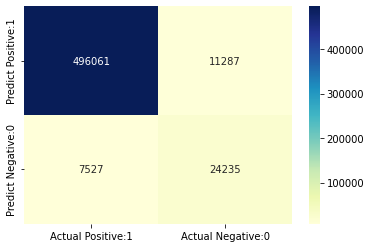

In [28]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [29]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    507348
           1       0.68      0.76      0.72     31762

    accuracy                           0.97    539110
   macro avg       0.83      0.87      0.85    539110
weighted avg       0.97      0.97      0.97    539110



In [30]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [31]:
# print classification accuracy

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

Classification accuracy : 0.9651


In [32]:
# print classification error

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

Classification error : 0.0349


In [33]:
# print precision score

precision = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(precision))

Precision : 0.9778


In [34]:
recall = TP / float(TP + FN)

print('Recall or Sensitivity : {0:0.4f}'.format(recall))

Recall or Sensitivity : 0.9851


In [35]:
true_positive_rate = TP / float(TP + FN)
print('True Positive Rate : {0:0.4f}'.format(true_positive_rate))

True Positive Rate : 0.9851


In [36]:
false_positive_rate = FP / float(FP + TN)
print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))

False Positive Rate : 0.3177


In [37]:
specificity = TN / (TN + FP)
print('Specificity : {0:0.4f}'.format(specificity))

Specificity : 0.6823


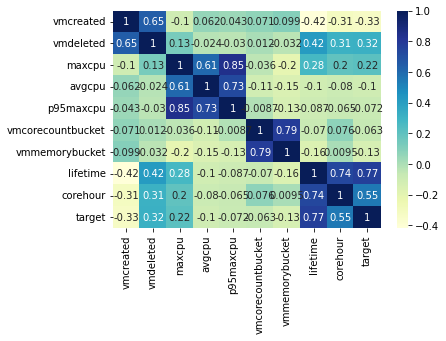

In [38]:
# plotting correlation heatmap
dataplot = sns.heatmap(trace_dataframe.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

In [39]:
# Observation
# corehour & lifetime is correlated with target i.e. Delay-insensitive & Others

In [40]:
X_train

array([[9.97105812e-01, 9.97221579e-01, 5.62314360e-01, ...,
        8.82352941e-02, 0.00000000e+00, 0.00000000e+00],
       [3.65941190e-01, 3.66288493e-01, 9.60517223e-01, ...,
        4.41176471e-01, 2.31561885e-04, 3.85894774e-05],
       [4.98495022e-01, 5.10997916e-01, 6.97926124e-02, ...,
        8.82352941e-02, 1.23885608e-02, 8.25814817e-04],
       ...,
       [4.74068071e-01, 4.74415374e-01, 3.23338392e-01, ...,
        8.82352941e-02, 2.31561885e-04, 1.54357910e-05],
       [0.00000000e+00, 1.00000000e+00, 7.78473009e-01, ...,
        8.82352941e-02, 1.00000000e+00, 6.66594633e-02],
       [9.33665200e-01, 9.47210002e-01, 9.09688719e-01, ...,
        2.94117647e-02, 1.34305893e-02, 8.95275876e-04]])

In [42]:
trace_dataframe[trace_dataframe['target'] == 1].describe()

,vmcreated,vmdeleted,maxcpu,avgcpu,p95maxcpu,vmcorecountbucket,vmmemorybucket,lifetime,corehour,target
count,1.596150e+05,1.596150e+05,159615.000000,159615.000000,159615.000000,159615.000000,159615.000000,159615.000000,159615.000000,159615.0
mean,1.383098e+05,2.425149e+06,87.966700,8.142823,36.949633,2.748326,8.105729,635.233088,1718.752502,1.0
std,3.990099e+05,4.585940e+05,17.234943,9.503910,28.377485,2.225715,10.898360,168.254763,1463.156457,0.0
min,0.000000e+00,6.027000e+05,0.036403,0.004883,0.028859,2.000000,2.000000,120.333333,240.666667,1.0
25%,0.000000e+00,2.591400e+06,84.808359,2.756611,10.536261,2.000000,2.000000,719.833333,1439.666667,1.0
50%,0.000000e+00,2.591400e+06,96.017085,5.689298,27.560936,2.000000,4.000000,719.833333,1439.666667,1.0
75%,0.000000e+00,2.591400e+06,98.464203,10.050941,62.366698,2.000000,8.000000,719.833333,1439.666667,1.0
max,2.067300e+06,2.591400e+06,100.000000,99.376264,100.000000,30.000000,70.000000,719.833333,21595.000000,1.0


In [43]:
trace_dataframe[trace_dataframe['target'] == 0].describe()

,vmcreated,vmdeleted,maxcpu,avgcpu,p95maxcpu,vmcorecountbucket,vmmemorybucket,lifetime,corehour,target
count,2.535933e+06,2.535933e+06,2.535933e+06,2.535933e+06,2.535933e+06,2.535933e+06,2.535933e+06,2.535933e+06,2.535933e+06,2535933.0
mean,1.248721e+06,1.335403e+06,5.366428e+01,1.605368e+01,4.781591e+01,3.879808e+00,1.670369e+01,2.408304e+01,7.693466e+01,0.0
std,7.710287e+05,7.721222e+05,3.693263e+01,1.907784e+01,3.609043e+01,4.348432e+00,1.538696e+01,1.137798e+02,4.778791e+02,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,8.333333e-02,1.666667e-01,0.0
25%,5.769000e+05,6.630000e+05,1.484034e+01,1.959539e+00,9.911397e+00,2.000000e+00,4.000000e+00,1.666667e-01,3.333333e-01,0.0
50%,1.220700e+06,1.305300e+06,5.770346e+01,8.435876e+00,4.935361e+01,2.000000e+00,8.000000e+00,4.166667e-01,1.333333e+00,0.0
75%,1.897500e+06,2.021700e+06,9.230984e+01,2.335342e+01,8.416641e+01,4.000000e+00,3.200000e+01,1.916667e+00,7.000000e+00,0.0
max,2.591400e+06,2.591400e+06,1.000000e+02,9.932801e+01,1.000000e+02,3.000000e+01,7.000000e+01,7.198333e+02,2.159500e+04,0.0


In [44]:
# we can recommend to perform this exercise on Delay-insensitive vms as they constitute more core hours and lifetime
# we can also see that delta between p95 and max cpu is higher
# we can also see that the average is lower wrt max cpu
# more spikes are observed

In [45]:
# introducing 3 more fields delmaxavg delmaxp95 delp95avg
trace_dataframe['delmaxavg'] = trace_dataframe['maxcpu'] - trace_dataframe['avgcpu']
trace_dataframe['delmaxp95'] = trace_dataframe['maxcpu'] - trace_dataframe['p95maxcpu']
trace_dataframe['delp95avg'] = trace_dataframe['p95maxcpu'] - trace_dataframe['avgcpu']

In [46]:
trace_dataframe[trace_dataframe['target'] == 1].describe()

,vmcreated,vmdeleted,maxcpu,avgcpu,p95maxcpu,vmcorecountbucket,vmmemorybucket,lifetime,corehour,target,delmaxavg,delmaxp95,delp95avg
count,1.596150e+05,1.596150e+05,159615.000000,159615.000000,159615.000000,159615.000000,159615.000000,159615.000000,159615.000000,159615.0,159615.000000,159615.000000,159615.000000
mean,1.383098e+05,2.425149e+06,87.966700,8.142823,36.949633,2.748326,8.105729,635.233088,1718.752502,1.0,79.823877,51.017067,28.806810
std,3.990099e+05,4.585940e+05,17.234943,9.503910,28.377485,2.225715,10.898360,168.254763,1463.156457,0.0,17.074361,25.638681,23.406638
min,0.000000e+00,6.027000e+05,0.036403,0.004883,0.028859,2.000000,2.000000,120.333333,240.666667,1.0,0.009563,0.000000,-2.404596
25%,0.000000e+00,2.591400e+06,84.808359,2.756611,10.536261,2.000000,2.000000,719.833333,1439.666667,1.0,75.879780,32.878318,7.014693
50%,0.000000e+00,2.591400e+06,96.017085,5.689298,27.560936,2.000000,4.000000,719.833333,1439.666667,1.0,86.570268,46.626264,21.066135
75%,0.000000e+00,2.591400e+06,98.464203,10.050941,62.366698,2.000000,8.000000,719.833333,1439.666667,1.0,90.084304,76.291099,51.940450
max,2.067300e+06,2.591400e+06,100.000000,99.376264,100.000000,30.000000,70.000000,719.833333,21595.000000,1.0,99.429264,99.100141,96.396597


In [50]:
# anomolous data
trace_dataframe[trace_dataframe['delp95avg'] < 0].describe()

,vmcreated,vmdeleted,maxcpu,avgcpu,p95maxcpu,vmcorecountbucket,vmmemorybucket,lifetime,corehour,target,delmaxavg,delmaxp95,delp95avg
count,5.330000e+02,5.330000e+02,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000
mean,5.047064e+05,1.909112e+06,83.061353,2.418145,1.660422,3.988743,20.833021,390.112570,1493.249218,0.489681,80.643209,81.400931,-0.757722
std,6.660730e+05,8.722939e+05,26.661177,1.388930,1.128104,4.435827,16.532387,342.778693,1326.835380,0.500363,26.034957,26.369862,0.740102
min,0.000000e+00,1.230000e+04,1.024593,0.061715,0.029750,2.000000,2.000000,1.583333,3.166667,0.000000,0.927623,0.933952,-2.404596
25%,6.540000e+04,9.711000e+05,84.187166,1.303841,1.018099,2.000000,4.000000,9.916667,20.333333,0.000000,82.368618,83.012003,-1.356969
50%,8.520000e+04,2.591400e+06,97.612103,2.482900,1.438309,4.000000,32.000000,696.166667,1439.666667,0.000000,94.125627,95.443116,-0.502333
75%,8.538000e+05,2.591400e+06,98.413332,3.452097,1.937499,4.000000,32.000000,701.666667,2785.333333,1.000000,95.598259,96.799029,-0.102664
max,2.584500e+06,2.591400e+06,100.000000,14.392508,14.105560,30.000000,70.000000,719.833333,3538.000000,1.000000,99.092683,99.100141,-0.000856


In [51]:
ts_target_df = trace_dataframe[trace_dataframe['delp95avg'] < 0]

In [52]:
ts_target_df.to_csv('p95avg_negative.csv')